# Human Faces - CalebA GAN

Make Your First GAN With PyTorch, 2020

In [ ]:
# mount Drive to access data files

from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [ ]:
# import libraries

import torch
import torch.nn as nn
from torch.utils.data import Dataset

import h5py
import pandas, numpy, random
import matplotlib.pyplot as plt

## Standard CUDA Check And Set Up

In [ ]:
# check if CUDA is available
# if yes, set default tensor type to cuda

if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass
#torch.set_default_device('cpu')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
#print("using processor: ",device)
device


using cuda: Tesla T4


/usr/local/lib/python3.10/dist-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


device(type='cuda')

## Dataset Class

In [ ]:
# dataset class

class CelebADataset(Dataset):

    def __init__(self, file):
        self.file_object = h5py.File(file, 'r')
        self.dataset = self.file_object['img_align_celeba']
        pass

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        if (index >= len(self.dataset)):
          raise IndexError()
        img = numpy.array(self.dataset[str(index)+'.jpg'])
        return torch.cuda.FloatTensor(img) / 255.0
        #return torch.FloatTensor(img)/255.0

    def plot_image(self, index):
        plt.imshow(numpy.array(self.dataset[str(index)+'.jpg']), interpolation='nearest')
        pass

    pass

In [ ]:
# create Dataset object

celeba_dataset = CelebADataset('/content/mount/MyDrive/Colab_Notebooks/celeba/celeba_aligned_small.h5py')

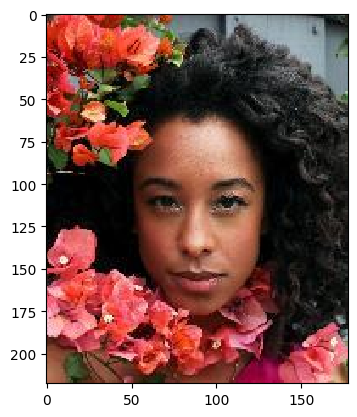

In [ ]:
# check data contains images

celeba_dataset.plot_image(43)

# Helper Functions

In [ ]:
# functions to generate random data

def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data


def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

In [ ]:
# modified from https://github.com/pytorch/vision/issues/720

class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape, # so we get a tuple

    def forward(self, x):
        return x.view(*self.shape)

## Discriminator Network

In [ ]:
# discriminator class

class Discriminator(nn.Module):

    def __init__(self):
        # initialise parent pytorch class
        super().__init__()

        # define neural network layers
        self.model = nn.Sequential(
            View(218*178*3), # change the 3-chanel data to 1-D array

            nn.Linear(3*218*178, 100),
            nn.LeakyReLU(),

            nn.LayerNorm(100),

            nn.Linear(100, 1),
            nn.Sigmoid()
        )

        # create loss function
        self.loss_function = nn.BCELoss()

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []

        pass


    def forward(self, inputs):
        # simply run model
        return self.model(inputs)


    def train(self, inputs, targets):
        # calculate the output of the network
        outputs = self.forward(inputs)

        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 1000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass


    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass

    pass

## Test Discriminator in GPU

In [ ]:
%%time
# test discriminator can separate real data from random noise

D = Discriminator()
# move model to cuda device
D.to(device)

for image_data_tensor in celeba_dataset:
    # real data
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    # fake data
    D.train(generate_random_image((218,178,3)), torch.cuda.FloatTensor([0.0]))
    pass

counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
CPU times: user 3min 39s, sys: 2.88 s, total: 3min 41s
Wall time: 3min 45s


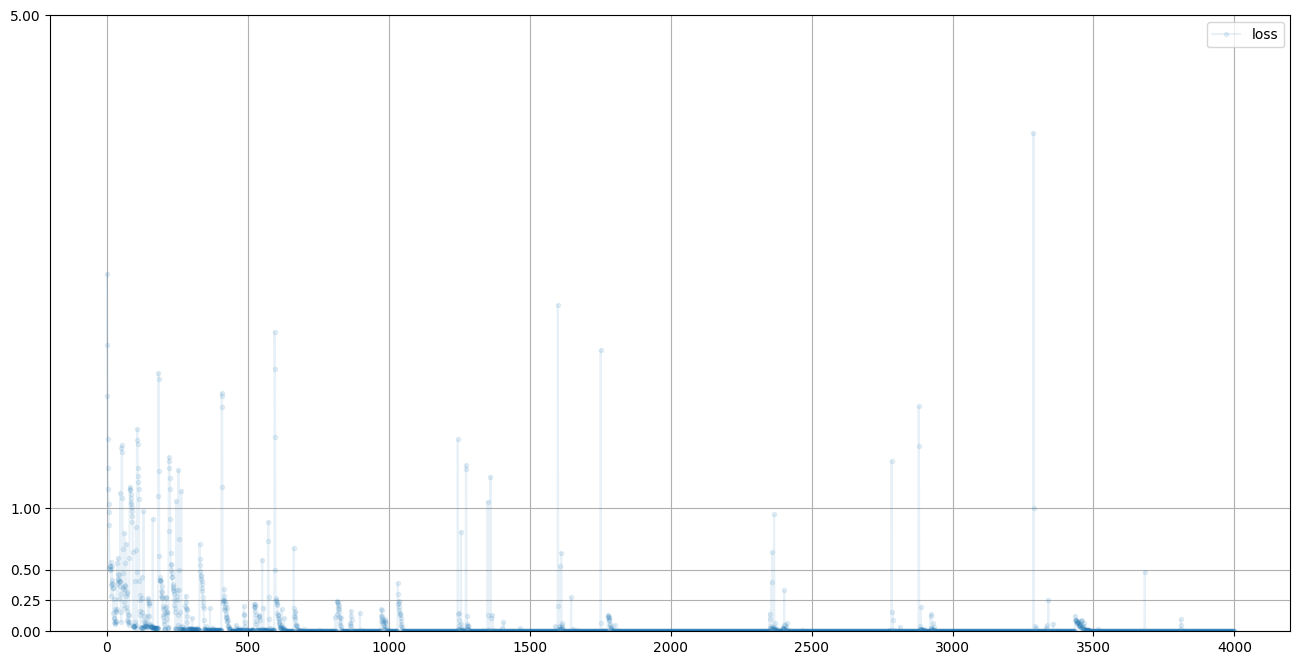

In [ ]:
# plot discriminator loss

D.plot_progress()

In [ ]:
# manually run discriminator to check it can tell real data from fake

for i in range(4):
  image_data_tensor = celeba_dataset[random.randint(0,20000)]
  print( D.forward( image_data_tensor ).item() )
  pass

for i in range(4):
  print( D.forward( generate_random_image((218,178,3))).item() )
  pass

0.9999815225601196
0.9998946189880371
0.9999237060546875
0.9999815225601196
0.00010152677714359015
0.00036072052898816764
9.984696953324601e-05
0.0001054669774021022


## Generator Network

In [ ]:
# generator class

class Generator(nn.Module):

    def __init__(self):
        # initialise parent pytorch class
        super().__init__()

        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(100, 3*10*10),
            nn.LeakyReLU(),

            nn.LayerNorm(3*10*10),

            nn.Linear(3*10*10, 3*218*178),

            nn.Sigmoid(),
            View((218,178,3))
        )

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0
        self.progress = []

        pass


    def forward(self, inputs):
        # simply run model
        return self.model(inputs)


    def train(self, D, inputs, targets):
        # calculate the output of the network
        g_output = self.forward(inputs)

        # pass onto Discriminator
        d_output = D.forward(g_output)

        # calculate error
        loss = D.loss_function(d_output, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass


    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass

    pass

## Test Generator Output

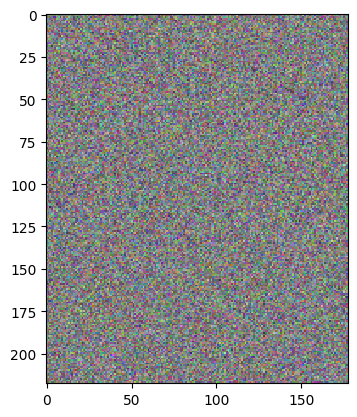

In [ ]:
# check the generator output is of the right type and shape

G = Generator()
# move model to cuda device
G.to(device)

output = G.forward(generate_random_seed(100))

img = output.detach().cpu().numpy()

plt.imshow(img, interpolation='none', cmap='Blues')

## Train GAN

In [ ]:
%%time

# create Discriminator and Generator

D = Discriminator()
D.to(device)
G = Generator()
G.to(device)

epochs = 4

for epoch in range(epochs):
  print ("epoch = ", epoch + 1)

  # train Discriminator and Generator

  for image_data_tensor in celeba_dataset:
    # train discriminator on true
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))

    # train discriminator on false
    # use detach() so gradients in G are not calculated
    D.train(G.forward(generate_random_seed(100)).detach(), torch.cuda.FloatTensor([0.0]))

    # train generator
    G.train(D, generate_random_seed(100), torch.cuda.FloatTensor([1.0]))

    pass

  pass

epoch =  1


<ipython-input-4-be382dab7ce6>:17: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:78.)
  return torch.cuda.FloatTensor(img) / 255.0


counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
epoch =  2
counter =  41000
counter =  42000
counter =  43000
counter =  44000
counter =  45000
counter =  46000
counter =  47000
counter =  48000
counter =  49000
counter =  50000
counter =  51000
counter =  52000
counter =  53000
counter =  54000
counter =  55000
counter =  56000
counter =  57000
counter =  58000
counter =  5

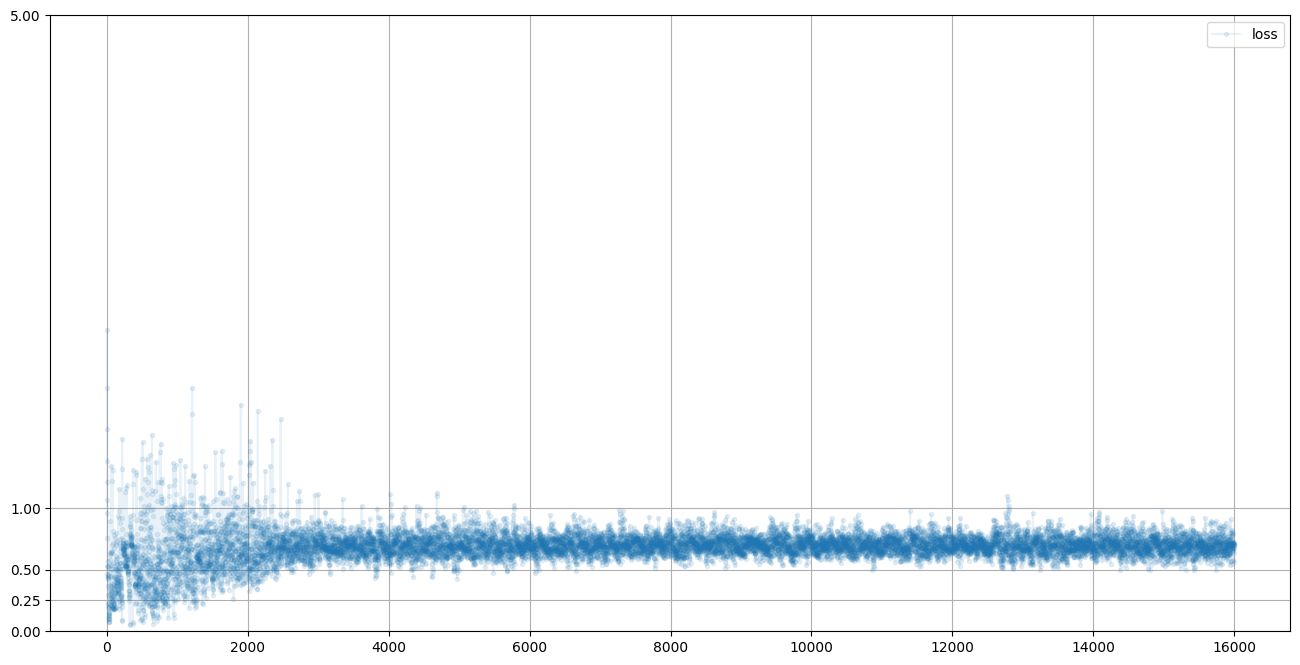

In [ ]:
# plot discriminator error

D.plot_progress()

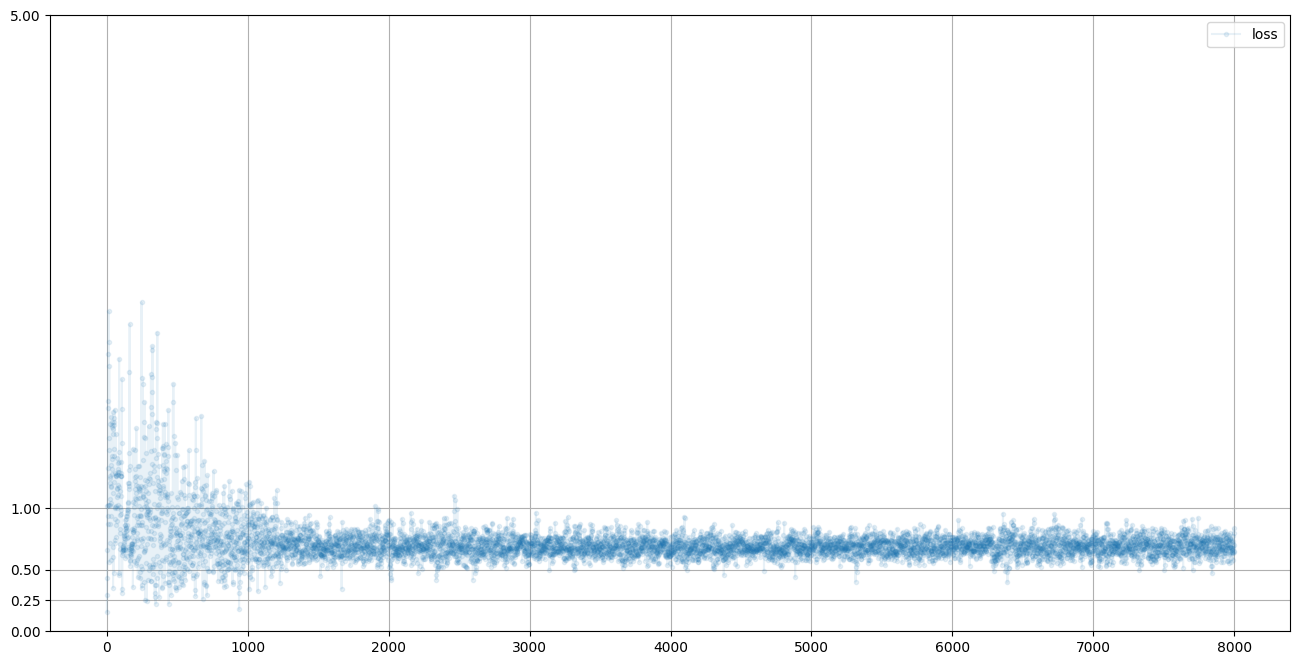

In [ ]:
# plot generator error

G.plot_progress()

## Run Generator

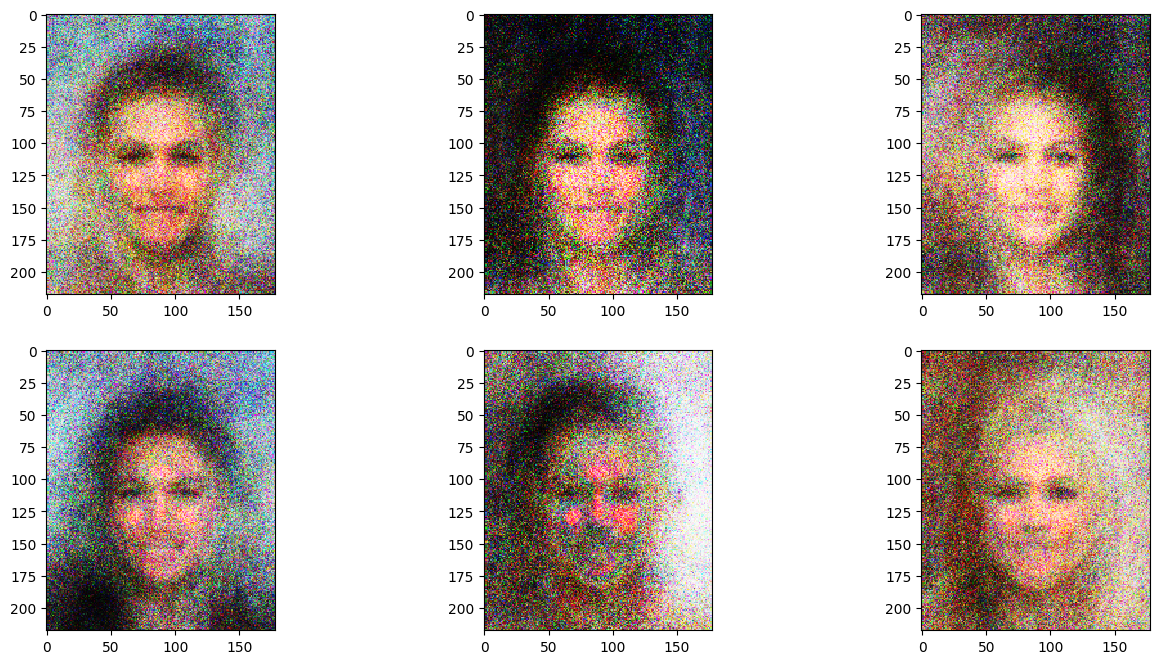

In [ ]:
# plot several outputs from the trained generator

# plot a 3 column, 2 row array of generated images
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        img = output.detach().cpu().numpy()
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        pass
    pass

# Memory Consumption

In [ ]:
# current memory allocated to tensors (in Gb)

torch.cuda.memory_allocated(device) / (1024*1024*1024)

0.7599925994873047

In [ ]:
# total memory allocated to tensors during program (in Gb)

torch.cuda.max_memory_allocated(device) / (1024*1024*1024)

1.5913934707641602

In [ ]:
# summary of memory consumption

print(torch.cuda.memory_summary(device, abbreviated=True))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    778 MiB |   1629 MiB |  32937 GiB |  32936 GiB |
|---------------------------------------------------------------------------|
| Active memory         |    778 MiB |   1629 MiB |  32937 GiB |  32936 GiB |
|---------------------------------------------------------------------------|
| Requested memory      |    774 MiB |   1621 MiB |  32843 GiB |  32843 GiB |
|---------------------------------------------------------------

In [ ]:
#!cat /proc/cpuinfo | grep model\ name
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed bhi
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
ad